# Advanced model
Rather than basic Linear model, Ensemble, etc that uses sklearn, and rather than using basic DNN, we'll do something more complicated that other uses (though they're not necessarily current SOTA on both model and techniques). 

The original notebook doing this is taken from [fastai course nlp](https://github.com/fastai/course-nlp/blob/master/5-nn-imdb.ipynb), and the ones that one make changes to fit with fastai v2 is [referenced here](https://github.com/Wabinab/fastai-coursenlp-v2_rewrite/blob/main/Chapter5.ipynb).

- Cleaning of data (With additional mapping all to American English from British English). 

## Cleaning Data
Information on British --> American: Get a mapping from the internet, get all unique words from the whole corpus, get all the words that're British, and find their corresponding American, and apply it throughout whole corpus using regex. 

In [32]:
from pathlib import Path
import xml.etree.ElementTree as ET
import gc

This is what one originally tries to do, get the British National Corpus from the internet, gather all English that are British, and check if our words have any British words and convert them to American based on another American Corpus. However, it proves that the corpus contains a lot of words that are shared with American as well, not just purely those distinctive words that're different. Hence this is a failure and stopped afterwards. 

In [33]:
path = Path("/home/fastai2/Music/BNC_Corpus/download/Texts/news")
this = path/"A1E.xml"

In [34]:
tree = ET.parse(this)
root = tree.getroot()
root.tag, root.attrib

('bncDoc', {'{http://www.w3.org/XML/1998/namespace}id': 'A1E'})

In [35]:
wtext = list(root)[1]
div1 = list(wtext)[0]
head1 = list(div1)[0]
s1 = list(head1)[0]
w1 = list(s1)[0]

In [36]:
w1.text

'Latest '

Let's skip that for now and we'll see how it goes later. 

In [37]:
from sklearn.datasets import fetch_20newsgroups
all_xs, all_y = fetch_20newsgroups(subset="all", remove=('headers', 'footers', 'quotes'),
                    shuffle=True, return_X_y=True)

In [38]:
sys.path

['/home/fastai2/notebooks/DataGlacier/NLP_GroupProject_DG/Week_12',
 '/home/fastai2/.vscode-server/extensions/ms-toolsai.jupyter-2021.10.1101450599/pythonFiles',
 '/home/fastai2/.vscode-server/extensions/ms-toolsai.jupyter-2021.10.1101450599/pythonFiles/lib/python',
 '/anaconda/envs/fastai/lib/python38.zip',
 '/anaconda/envs/fastai/lib/python3.8',
 '/anaconda/envs/fastai/lib/python3.8/lib-dynload',
 '',
 '/anaconda/envs/fastai/lib/python3.8/site-packages',
 '/anaconda/envs/fastai/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg',
 '/anaconda/envs/fastai/lib/python3.8/site-packages/IPython/extensions',
 '/home/fastai2/.ipython',
 '/home/fastai2/notebooks/DataGlacier/NLP_GroupProject_DG/python_files']

In [39]:
from fastai.text.all import *
from tqdm.notebook import tqdm
import sys
parent_path = Path("/home/fastai2/notebooks/DataGlacier")
sys.path.append(str(parent_path/"NLP_GroupProject_DG/python_files"))

from nlputils import *

In [40]:
k = 7

choice = np.load(f"choice_{k}.npy")
g = threshold_subset(all_xs, k)
all_xs = np.array(all_xs)[g]
all_y = np.array(all_y)[g]
print("Finish thresholding. ")

g = choice < 0.1
all_xs = all_xs[g]
all_y = all_y[g]
print("Finish removing xxunk above threshold.")

# doesn't change all_y
all_xs = np.array([clean_data(x, False) for x in tqdm(all_xs)])
print("Finish cleaning data.")
len(all_xs)

Finish thresholding. 
Finish removing xxunk above threshold.


  0%|          | 0/11708 [00:00<?, ?it/s]

Finish cleaning data.


11708

One is thinking of doing this manually. Thing is, one isn't even sure if we could deal with everything. There's no promise. 

And we don't have to do it for **everything**, just those that are confusing. WE could still mix british english and american english **as long as there're no confusion** (such as both being used). For a single word, if there is only in British English used all the time, just do that. 

**Weakness**: When you try to apply it to real product, you need to check again for any British English because the corpus **cannot contain all** British English. 

There are also some thing on non-english words. One is thinkingo f just leaving it there, because there seems to be some that contains these and we don't really know how to clean these things out without doing quite a lot of work. (brute force comparison with english dictionary, and then have to decide again things especially for science like SCSI that's a computer term but not in the English dict, etc that is complicated). So we'll just leave it there as some noise. 

In [41]:
try: counter = load_pickle(f"counter_{k}.pkl")
except Exception: 
    counter = Counter()
    for data in tqdm(all_xs): counter += Counter(data.split())
    save_pickle(f"counter_{k}.pkl", counter)

- Lower all cases
- Remove all punctuations

In [42]:
def strip_punc(s): 
    return s.translate(str.maketrans('', '', string.punctuation))

# lower all cases
our_vocab = {v.lower() for v in counter}
del counter

# remove all punctuations
our_vocab = {strip_punc(v) for v in our_vocab}

We ignore some things like `endeavor` can only be used as verb but it's British English type can be used both as verb and noun thingy. Too complicated. 

Commonly we'll have these [spelling method](https://www.oxfordinternationalenglish.com/differences-in-british-and-american-spelling/) differences and we also have [common words](https://www.thoughtco.com/american-english-to-british-english-4010264)

In [43]:
# Discovery method
from IPython.display import clear_output


def brit_to_amer(ending, brit_rule, americ_rule):
    r = re.compile(ending)
    compare_list = list(filter(r.match, our_vocab))
    ame_list = [re.sub(brit_rule, americ_rule, s) for s in compare_list]

    non_empty = {}
    for b, a in tqdm(zip(compare_list, ame_list)):
        m = re.compile(rf'{a}')
        z = list(filter(m.match, our_vocab))
        if a in z: non_empty[b] = a

    return non_empty


british_eng = {
    "rumour": "rumor",
    "vapour": "vapor",
    "arbour": "arbor",
    "colour": "color",
    "behaviour": "behavior",
    "saviour": "savior",
    "favour": "favor",
    "armour": "armor",
    "honour": "honor",
    "inferiour": "inferior",
    "labour": "labor",
    "humour": "humor",
    "endeavour": "endeavor",
    "harbour": "harbor",
    "fervour": "fervor",
    "parlour": "parlor",
    "neighbour": "neighbor",
    "flavour": "flavor",
    "belabour": "belabor",
    'survivour': 'survivor',  # end of our --> or.
    'aerial': "antenna",
    'anywhere': 'anyplace', 
    # 'autumn': 'fall'   # which fall we're deciding? fall or fall?
    "solicitor": "attorney",
    'biscuit': 'cookie',
    'bonnet': 'hood',
    'janitor': 'aretaker',
    'constable': 'patrolman',
    'dynamo': 'generator',
    # and others it's just too many one decide to leave it here for now. 
}

# our to or is too dirty to be used. 
british_eng.update(brit_to_amer(r'[a-z]+ise$', r'ise', r'ize')) # ise --> ize. 
british_eng.update(brit_to_amer(r'[a-z]+yse$', 'yse', 'yze'))  # use --> yze
british_eng.update(brit_to_amer(r'[a-z]+ae[a-z]$', 'ae', 'e'))  # ae --> e
del british_eng["michael"], british_eng["laer"], british_eng["caen"]
del british_eng["raes"]
# oe --> e checked nothing useful (mostly useful translated become rubbish)
british_eng.update({'defence': 'defense',
 'sence': 'sense',
 'selfdefence': 'selfdefense',
 'nonsence': 'nonsense',
 'pretence': 'pretense',
 'absence': 'absense',
 'essence': 'essense',
 'licence': 'license',
 'offence': 'offense'})  # ence --> ense after deleting rubbish.
british_eng.update({'catalogue': 'catalog'})  # ogue --> og. 
# spelling


clear_output()
# british_eng = defaultdict(str, british_eng)
# british_eng

Spelling mistakes are done manually when we check the output of stuffs and hence depends on my expertize in English. 

In [44]:
spelling_mistakes = {
    "bahaviour": "behavior",
    "excercise": "exercise",
    "supprise": "surprise",
    "suprise": "surprise",
    "appologise": "apologize",
    "appologize": "apologize",
    'excersise': "exercise",
    'oterwise': "otherwise",
    "frnachise": "franchise",
    "fulfullment": "fulfillment",
    'usuallu': "usually",
    'specfically': "specifically",
    'espically': "especially",
    "talll": "tall",
    'usally': "usually",
    'ususally': "unusually",
    'adventually': 'eventually',
    'oscialltor': 'oscillator',
    'xcellerator': 'accelerator',
    'reccollecting': 'recollecting',
    'osciallator': 'oscillator',
    'unballance': 'unbalance',
    'congroller': 'controller',
    'weeeeelllllll': 'well',
    'killig': 'killing',
    'oscilliscope': "oscilloscope",
    "ussually": "usually",
    'knoew': 'knew',
    "hense": "hence",
    
}

spelling_mistakes.update(brit_to_amer(r'[a-z]+lll[a-z]+$', 'lll', 'll'))

0it [00:00, ?it/s]

Replace spelling mistakes before british to american. 

In [45]:
def word_neutralizer(spell, brit_to_amer, word, return_type="str"):
    """
    Neutralizes word(s). 

    :spell: (dict/equivalent) contains spelling mistakes. Mistakes are the 
        keys and corrected words are the values. 
    :brit_to_amer: (dict/equivalent) british to american. British English 
        as keys, American English as values. (Could be reversed if you
        with it to be the other way round).
    :word: (str/list/equivalent) Word(s) that we want to clean. 
    :return_type: (str) The return type. Make sure what you enter are in
        quotations and they're imported/legible type or this whole function
        will fail. 

    :return: cleaned words. 
    """
    # spell = defaultdict(str, spell)
    # brit_to_amer = defaultdict(str, brit_to_amer)

    # changes spelling mistakes first before brit_to_amer
    for k, v in spell.items(): word = word.replace(k, v)
    for k, v in brit_to_amer.items(): word = word.replace(k, v)
    return word

In [46]:
assert word_neutralizer(spelling_mistakes, british_eng, "hense colour") == "hence color"
assert word_neutralizer(spelling_mistakes, british_eng, "hense color") == "hence color"
assert word_neutralizer(spelling_mistakes, british_eng, "hence colour") == "hence color"
assert word_neutralizer(spelling_mistakes, british_eng, "hence color") == "hence color"

In [47]:
word_neutralizer(spelling_mistakes, british_eng, all_xs[155])

'\n\nWell 48 bit color *could* be for improved resolution but 16 bits per channel\nseems like a bit excessive. I have seen a paper that quoted 10 bits per channel\nof 12 bits for computational precision. More than that would seem to be wasted.\n\nPerhaps the frame buffer uses another colorspace which needs more bits to\nrepresent the full range - RGB is a cube so it is a compact encoding.\n\nMost likely however is that there are two separate 24 bit (8 bits per component)\nframe buffers. This set up, called double buffering, allows a complex 3d picture\nto be built up on one buffer while the other buffer (containing the previous\nframe) is displayed. This makes for smoother animation.\n\n\nWell hey if you want to brag about numbers, the 5000 range can take a PXG Turbo+\ncard with 96 bits per pixel. Full double buffering (Two 24 bit buffers), a 24\nbit Z buffer and an extra 24 bit buffer for off screen image storage.\n\nMind you the card costs more than your workstation.\n\n--\nChris Lil

In [48]:
for k in tqdm(range(len(all_xs))):
    all_xs[k] = word_neutralizer(spelling_mistakes, british_eng, all_xs[k])

  0%|          | 0/11708 [00:00<?, ?it/s]

In [49]:
df = pd.DataFrame([all_xs, all_y]).T
df.columns = ["text_", "category"]

# ULMFiT

We are using a method called ULMFiT: which this AWD-LSTM are pretrained on (English) wikipedia text (corpus name wikitext-103). Then, we will do transfer learning and fine tune it on our corpus, then only we do the classification task removing AWD-LSTM's head for second transfer learning. 

We are on the pretraining stage. 

Note this requires quite a lot of RAM so if you have smaller RAM, play around with the batch size, seq_len, etc (or more easier, rent a vm with a larger RAM).

In [50]:
RETRAIN = False if "fine_tuned_enc.pth" in os.listdir("models") else True
RETRAIN

True

In [51]:
if RETRAIN:
    bs = 96
    dls_lm = TextDataLoaders.from_df(df, is_lm=True, bs=bs,
                n_workers=os.cpu_count() * 2)
    dls_lm.show_batch(max_n=2)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj actually , i find the stuff about xxup jc being a carpenter more \n interesting . xxmaj is there an independent source for this assertion , \n or is it all from the xxmaj christian xxmaj bible ? xxmaj is there any record at \n all of anything he built ? a table , a house , some stairs ( norm \n xxmaj abrams says the real test of a","xxmaj actually , i find the stuff about xxup jc being a carpenter more \n interesting . xxmaj is there an independent source for this assertion , \n or is it all from the xxmaj christian xxmaj bible ? xxmaj is there any record at \n all of anything he built ? a table , a house , some stairs ( norm \n xxmaj abrams says the real test of a carpenter"
1,"of the \n pool , a man who xxunk 1,700 workers ? xxmaj now , it 's true , there was a \n reduction , but for sure there are still 1,200 conductors working for him . xxmaj and \n if someone who xxunk a staff that size says things like that , then what \n can you expect from a simple , uneducated , politically unsophisticated person ? ! \n xxmaj","the \n pool , a man who xxunk 1,700 workers ? xxmaj now , it 's true , there was a \n reduction , but for sure there are still 1,200 conductors working for him . xxmaj and \n if someone who xxunk a staff that size says things like that , then what \n can you expect from a simple , uneducated , politically unsophisticated person ? ! \n xxmaj he"


`wd` stands for weight decay, particularly L2 regularization. `drop_mult` stands for Dropouts, particularly there're lots of dropouts in `AWD_LSTM` and there're a preset numbers for each of them that are tuned for it to work, and for experts we could use lower level fastai's API to tune them manually but usually the default are good enough so we have this `drop_mult` as a multiplier to **each of the dropouts value**, controlling all at once rather than separately. 

/anaconda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


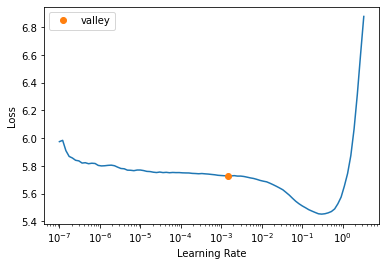

In [52]:
if RETRAIN:
    learn = language_model_learner(dls_lm, AWD_LSTM, pretrained=True, 
                metrics=[accuracy, Perplexity()], wd=0.1, drop_mult=0.3,
                moms=(0.8, 0.7, 0.8)).to_fp16()
    learn.lr_find()

When you use `learn.fine_tune()` nowadays, by default it will **train the last layer** for **one epoch** (which could be changed by changing `freeze_epochs`), and then you can train for `epochs` number thereafter. The **total number of epochs trained** is `freeze_epochs + epochs`. 

In [53]:
if RETRAIN: 
    lr = 5e-3
    lr *= bs/48
    learn.fine_tune(3, lr*10, moms=(0.8, 0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.792135,4.941532,0.217837,139.984558,13:58


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.189518,4.410872,0.263131,82.341270,16:06
1,3.905921,4.060105,0.304952,57.980389,16:06
2,3.497552,3.809278,0.331691,45.117844,16:04


One epoch training 0.311626 results. 10 epochs check `std_log.txt` training on another VM got 0.34+ results. 

In [54]:
save_path = Path(os.getcwd())/"models" # this is gitignored as it's v.big. 
if RETRAIN:   
    learn.save(save_path/"fine_tuned")
    learn.save_encoder(save_path/"fine_tuned_enc")

Next we **load ONLY the encoder** for classification. Particularly because the encoder is the *body* of the model that isn't changed, and those that are not the encoder are called the *head* (which is specific for different task). Now that we're not doing text prediction but text classification, we have a different task, hence different head; but the body (encoder) stays the same as before. That's why we load weights for the encoder only, not the whole model. 

In [55]:
vocab = dls_lm.vocab
try: del learn, dls_lm
except Exception: pass
torch.cuda.empty_cache()
gc.collect()

17337

In [56]:
sl = 72  # sequence length. 
bs = 36

dls = DataBlock(
    blocks=(TextBlock.from_df("text_", vocab=vocab, seq_len=sl, tok=SpacyTokenizer("en")),
            CategoryBlock),
    get_x=ColReader("text"), get_y=ColReader("category"),
    splitter=RandomSplitter(0.1)
).dataloaders(df, bs=bs, num_workers=os.cpu_count()*2, seq_len=sl)

dls.show_batch(max_n=2)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj archive - name : hockey - faq \n\n rec.sport.hockey answers to xxmaj frequently xxmaj asked xxmaj questions and other news : \n▁\n xxmaj contents : \n\n 0 . xxmaj new xxmaj info . \n 1 . xxup nhl \n 2 . xxup nhl xxmaj minor xxmaj leagues \n 3 . xxmaj college xxmaj hockey ( north xxmaj america ) \n 4 . xxmaj other leagues ( e.g. xxmaj europe , xxmaj canada xxmaj cup tournament ) \n 5 . xxmaj e - mail files \n 6 . xxup usenet xxmaj hockey xxmaj pool \n 7 . xxmaj up - coming xxmaj dates \n 8 . xxmaj answers to some frequently asked questions \n 9 . xxmaj miscellaneous \n▁\n▁ xxmaj send comments , suggestions and criticisms regarding this xxup faq list via e- \n mail to \n▁\n▁ xxrep 74 - \n▁\n▁ 0 . xxmaj new xxmaj info . \n▁\n▁",10
1,"xxbos xxmaj accounts of anti - armenian xxmaj human xxmaj right xxmaj violations in xxmaj azerbaijan # 008 xxmaj part b \n▁ xxmaj prelude to xxmaj current xxmaj events in nagorno - karabakh \n\n\t\t\t\t ( part b of # 008 ) \n\n▁ + xxrep 66 - + \n▁\n▁ "" oh , yes , i just remembered . xxmaj while they were raping me they \n▁ repeated quite frequently , "" let the xxmaj armenian women have babies \n▁ for us , xxmaj muslim babies , let them bear xxmaj azerbaijanis for the \n▁ struggle against the xxmaj armenians . "" xxmaj then they said , "" those \n▁ xxmaj muslims can carry on our holy cause . xxmaj heroes ! "" xxmaj they repeated \n▁ it very often . "" \n▁\n▁ + xxrep 66 - + \n\n▁ … continued from xxup part xxup a : \n\n xxmaj the six of",17


Note we'll perform "gradual unfreezing" here for training. 

Note the transfer learning we take from another learning platform seems to fail here due to mismatch of shape. We don't know what happens with that either. 

In [57]:
learn_c = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.3,
                metrics=accuracy, moms=(0.8, 0.7, 0.8)).to_fp16()
learn_c.load_encoder(save_path/"fine_tuned_enc")
learn_c.freeze()

/anaconda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.00363078061491251)

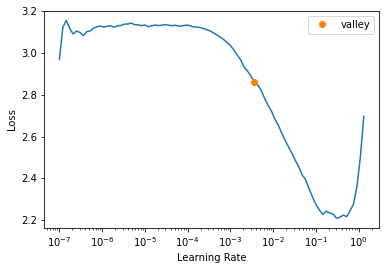

In [58]:
learn_c.lr_find()

In [59]:
learn_c.fit_one_cycle(2, 1e-2, moms=(0.8, 0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.925811,0.725234,0.775214,04:55
1,0.714978,0.646636,0.792308,04:57


In [60]:
learn_c.save(save_path/"first")

Path('/home/fastai2/notebooks/DataGlacier/NLP_GroupProject_DG/Week_12/models/first.pth')

#### Unfreeze last two layers and train for one cycle, save intermediate result.

In [61]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.772631,0.667861,0.781197,05:59
1,0.557457,0.605630,0.799145,05:59


In [62]:
learn_c.save(save_path/"second")

Path('/home/fastai2/notebooks/DataGlacier/NLP_GroupProject_DG/Week_12/models/second.pth')

#### Unfreeze last three layers and train for one cycle, and save intermediate result. 

In [63]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(3e-3/(2.6**4), 3e-3), moms=(0.8, 0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.531100,0.654522,0.804273,09:29
1,0.322739,0.594309,0.820513,09:31


In [64]:
learn_c.save(save_path/"third")

Path('/home/fastai2/notebooks/DataGlacier/NLP_GroupProject_DG/Week_12/models/third.pth')

#### Unfreeze all layers, train for two cycles, and save the result. 
If encountered `CUDA ERROR: unspecified launch failure`, try on the second try (i.e. run the code cell one more time again). 

In [65]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.248832,0.611578,0.818803,12:35
1,0.177222,0.610581,0.826496,12:33


In [66]:
learn_c.save(save_path/"final_model")

Path('/home/fastai2/notebooks/DataGlacier/NLP_GroupProject_DG/Week_12/models/final_model.pth')

### Noticed things:
- This notebook was created on an instance with a single K80 GPU. However, training was tested on a V100 GPU, and these are the conclusions: 

- During pretraining, K80 takes about 15-17 minutes per epoch, while for K80 it's 6-7 minutes per epoch. It's quite an improvement, but consider that P100 gives about 8-9 minutes per epoch, it's not a big improvement as starting from V100, FP16 should be used and exponential increment is expected but not really seen here. (Although we use `to_fp16()`, it does check whether the GPU supports or not, and if not support, it won't use FP16). 

- For classification task, this is where the improvement allows. K80 takes quite some time depending on how many models to train. Training for last layer only takes 5 minutes, last two layers about 6 minutes, last three layers about 9-10 minutes, and whole model takes more than 10 minutes. However, for V100, it only takes about 30 seconds for last layer only, up to 1 min for whole model. This is what we expect to see. 

- Longer pretraining doesn't necessarily means it'll do better classification task. All in all, the tricks on hyperparameter tuning the epochs/lr/etc on classification model are as important for better results. Results currently capped at less than 0.83 for a few variations in hyperparameters of training. It is unsure whether longer training time (more epochs) will give better result. 